# learnable positional embedding (Adding)

### Step1: building an learnable vector with shape (1, n) inside the CNN.<br> Step2: adding the vector to inputs.

## Libraries

In [14]:

from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torchsummary import summary
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR
import os
import argparse

import glob
import pickle
import data_loader

# Path

In [5]:
print(os.getcwd())

C:\Users\Administrator-1\Experiment_2\cnn_transformer_pe


In [6]:
training_data_kok14_galfa = os.path.join(os.getcwd(),"data", "other", "training_data_kok14_galfa.pickle")

## Data preparation

In [7]:
data = pickle.load(open(training_data_kok14_galfa, 'rb'))
# training data
X_train = data['X_train']
Y_train = data['Y_train']
# Observed test data
X_test = data['X_test']
Y_test = data['Y_test']

## Split train, validation and testing set from X_train and Y_train with percentage of 60%, 20%, 20%.

In [8]:

x_train, x_test, y_train, y_test = train_test_split(X_train,
                                                    Y_train,
                                                    test_size=0.2,
                                                    shuffle = True, 
                                                    random_state = 8)

x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train,
                                                  test_size=0.25,
                                                  random_state= 8) 

In [9]:
print("x_train=",x_train.shape, ", y_train=", y_train.shape)
print("x_val=",x_val.shape, ", y_val=", y_val.shape)
print("x_test=",x_test.shape, ", y_test=", y_test.shape)

x_train= (23268, 414) , y_train= (23268, 2)
x_val= (7756, 414) , y_val= (7756, 2)
x_test= (7757, 414) , y_test= (7757, 2)


## Plot a few training samples

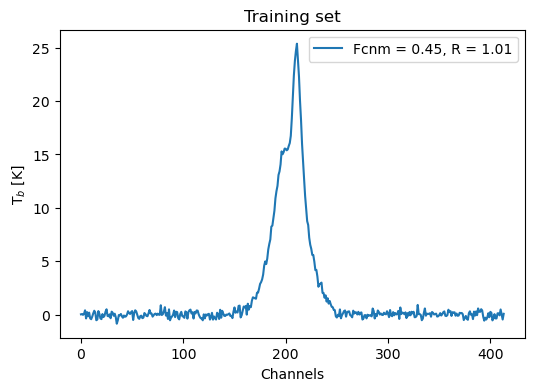

In [8]:
# Spectrum in training set
plt.figure(figsize=(6,4))
plt.plot(X_train[0, :], label=f'Fcnm = {round(Y_train[20000,0], 2)}, R = {round(Y_train[0,1], 2)}')

plt.title('Training set')
plt.xlabel('Channels')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

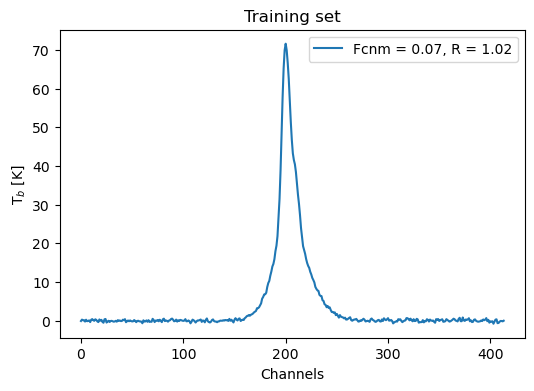

In [9]:
# Spectrum in training set
plt.figure(figsize=(6,4))
plt.plot(X_train[1000, :], label=f'Fcnm = {round(Y_train[10000,0], 2)}, R = {round(Y_train[10000,1], 2)}')

plt.title('Training set')
plt.xlabel('Channels')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

## Data loader

In [15]:

dataset_train = data_loader.spectra_loader(x_train,
                                           y_train,
                                           transform=data_loader.ToTensor(), 
                                           target_transform=data_loader.ToTensor(),
                                           pe=None)

dataset_val = data_loader.spectra_loader(x_val, 
                                         y_val,
                                         transform=data_loader.ToTensor(), 
                                         target_transform=data_loader.ToTensor(),
                                         pe=None)

dataset_test = data_loader.spectra_loader(x_test, 
                                          y_test,
                                          transform=data_loader.ToTensor(),
                                          target_transform=data_loader.ToTensor(),
                                          pe=None)

In [16]:
# initialize data loader
batch_size = 20 
train_loader = torch.utils.data.DataLoader(dataset = dataset_train,
                                           batch_size = batch_size, 
                                           shuffle =True)

valid_loader = torch.utils.data.DataLoader(dataset = dataset_val,
                                           batch_size = batch_size, 
                                           shuffle =False)

test_loader = torch.utils.data.DataLoader(dataset = dataset_test,
                                          batch_size = batch_size, 
                                          shuffle =False)

In [17]:
# test data loader
val = iter(test_loader)
A,B = next(val)
print(A.shape)
print(B.shape)

torch.Size([20, 1, 1, 414])
torch.Size([20, 2])


## Transformer Positional Encoder

In [19]:
class PositionalEncoding(nn.Module):
    # custom code
    def __init__(self,num_features, sequence_len=6, d_model=9):
        super(PositionalEncoding, self).__init__()
        if torch.cuda.is_available():
            self.device='cuda:0'
        else:
            self.device='cpu'
        pe = torch.zeros((1, sequence_len, d_model), dtype=torch.float32).to(self.device)
        factor = -math.log(10000.0) / d_model  # outs loop
        for index in range(0, sequence_len):  # position of word in seq
            for i in range(0, d_model, 2):
                div_term = math.exp(i * factor)
                pe[0, index, i] = math.sin(index * div_term)
                if(i+1<d_model):
                    pe[0, index, i+1] = math.cos(index * div_term)
                
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

## Model

In [15]:
# CNN_transformer
class cnn_transformer(nn.Module):
    def __init__(self, num_output=2, in_channels=1, input_row = 2, input_column=414, drop_out_rate=0, pe=False):
        super(cnn_transformer, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, 414))
        self.num_features = 54
        self.drop_rate=drop_out_rate
        self.pos_encoder = PositionalEncoding(num_features=self.num_features, sequence_len=6, d_model=9)
        self.pe=pe
        
        # CNN layers
        if(input_row>=2):
            self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels=72, 
                               kernel_size=(2,6), stride=1, padding=0, 
                               bias=True, padding_mode='zeros')
        else:
            self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels=72, 
                               kernel_size=(1,6), stride=1, padding=0, 
                               bias=True, padding_mode='zeros')
            
        self.bn1 = nn.BatchNorm2d(72)
        
        self.conv2 = nn.Conv2d(in_channels= 72, out_channels=64,
                               kernel_size=(1,40), stride=1, padding=0, bias=True,
                               padding_mode='zeros')
        
        self.bn2 = nn.BatchNorm2d(64)
            
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels=56,
                               kernel_size=(1,6), stride=1, padding=0, bias=True, 
                               padding_mode='zeros')
        
        self.bn3 = nn.BatchNorm2d(56)
        
        self.conv4 = nn.Conv2d(in_channels= 56, out_channels=48, 
                               kernel_size=(1,40), stride=1, padding=0, bias=True,
                               padding_mode='zeros')
        
        self.bn4 = nn.BatchNorm2d(48)
        
        self.conv5 = nn.Conv2d(in_channels = 48, out_channels=40, 
                               kernel_size=(1,6), stride=1, padding=0,
                               bias=True, padding_mode='zeros')
        
        self.bn5 = nn.BatchNorm2d(40)
        
        self.conv6 = nn.Conv2d(in_channels= 40, out_channels=32, 
                               kernel_size=(1,40), stride=1,
                               padding=0, bias=True, padding_mode='zeros')
        
        self.bn6 = nn.BatchNorm2d(32)
        
        self.conv7 = nn.Conv2d(in_channels = 32, out_channels=16, 
                               kernel_size=(1,6), stride=1, padding=0, 
                               bias=True, padding_mode='zeros')
        
        self.bn7 = nn.BatchNorm2d(16)
        
        self.conv8 = nn.Conv2d(in_channels= 16, out_channels=8, 
                               kernel_size=(1,40), stride=1, 
                               padding=0, bias=True, padding_mode='zeros')
        
        self.bn8 = nn.BatchNorm2d(8)
        
        self.linear = nn.Linear(1904, 54)
        
        self.flatten = nn.Flatten()
        
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=9,
                nhead=3,
                dim_feedforward=36,
                dropout=self.drop_rate,
                batch_first=True,
            ),
            num_layers=4
        )
        
        self.decoder = nn.Linear(54, num_output)

        # init parameter
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0]*m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        x = x + self.pos_embedding
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        #print(2, x.size())
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        #print(3, x.size())
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        #
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        #
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        #
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        #
        x = self.conv7(x)
        x = self.bn7(x)
        x = F.relu(x)
        #
        x = self.conv8(x)
        x = self.bn8(x)
        x = F.relu(x)
        #x = torch.squeeze(x)
        #x = x.reshape(-1, x.shape[2], x.shape[1])
        #
        #print(3, x.size()) #= (20,8,1,238)
        x = self.flatten(x) #1904
        x = self.linear(x)
        #print(3, x.size())
        x = x.reshape(x.shape[0], -1, 9)
        #print(3, x.size())
        if(self.pe==True):
            x = self.pos_encoder(x)
        # Transformer MODEL
        x = self.transformer(x)
        x = self.flatten(x)
        #print(5, x.size())
    
        x = self.decoder(x)
        return x

## Model Training and Evaluation 

In [21]:
# train 
def train(epoch):
    """
    Train the model.
    Parameters
    ----------
    epoch : int.
        the index of epoch.

    Returns
    -------
    train_loss/total: The mean MSE in an epoch.     
    """
    model.train()
    train_loss = 0
    total = 0
    for index, (inputs, values) in enumerate(train_loader):
        inputs = inputs.float()
        values = values.float()
        inputs, values = inputs.to(device), values.to(device)
        # forward
        outputs = model(inputs)
        loss = loss_function(outputs, values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print info
        train_loss = train_loss + (loss.item()*values.size(0)) 
        total += values.size(0)
    print("total loss=",train_loss)
    return train_loss/total

In [22]:
def validation(epoch):
    """
    validate the model.
    Parameters
    ----------
    epoch : int.
        the index of epoch.

    Returns
    -------
    error: The mean MSE in validation set. 
        
    """
    model.eval()
    global best_err
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(valid_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward
            outputs = model(inputs)
            loss = loss_function(outputs, values)
            test_loss = test_loss + (loss.item()*values.size(0))
            total += values.size(0)
    # Save checkpoint.
    error =  test_loss / total
    print(f"validation MSE in epoch {epoch}= ", error)
    if error < best_err:
        print('best_err:', error, 'Saving..')
        state = {'net': model.state_dict(),
                 'err': error,
                 'optimizer_state_dict': optimizer.state_dict(),
                 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/s6_learnable_add.pth')
        best_err = error
    return error

In [23]:
def test(epoch):
    """
    test the model.
    Parameters
    ----------
    epoch : int.
        the index of epoch.
    Returns
    -------
    error: The mean MSE in test set. 
    """
    model.eval()
    global best_err
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(test_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            #outputs = outputs.view(outputs[0], 1, outputs[1])
            loss = loss_function(outputs, values)
            test_loss =test_loss+ (loss.item()* values.size(0))
            total += values.size(0)
        #print(f'Test performance in epoch {epoch}: avg_error = {test_loss/total}')
        return test_loss/total

## Training: 10 trails

In [19]:
# define number of trails, number of epoch and learning rate
num_trial = 10
num_epoch = 80
learning_rate = 0.005
# the savier of best validation performance and coresponding testing performance.
vali = []
testing = []
# saver for each trials
train_trails = []
validate_trails =[]
test_trails = []

In [20]:
def trail(num_epoch):
    global vali
    global testing
    global scheduler
    global model
    global lr
    #define savor
    global train_trails
    global validate_trails
    global test_trails
    for epoch in range(num_epoch):
        train_err = train(epoch)
        vali_err = validation(epoch)
        scheduler.step()
        test_err = test(epoch)
        # save data
        train_trails.append(train_err)
        validate_trails.append(vali_err)
        test_trails.append(test_err)
    # final test
    validation_error,test_error = validate_model()
    print("test err=",test_error)
    vali.append(validation_error)
    testing.append(test_error)

In [24]:
def validate_model():
    global model
    model = cnn_transformer(num_output=2,
                            in_channels=1, 
                            input_row = 1,
                            input_column=414, 
                            drop_out_rate=0, 
                            pe=True)
    
    num_step = len(X_train)/batch_size
    loss_function = nn.MSELoss()
    best_err = 100000
    checkpoint = torch.load('./checkpoint/s6_learnable_add.pth',
                            map_location=torch.device('cuda:0'))
    model.load_state_dict(checkpoint['net'])
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    validation_error = validation(epoch)
    test_error = test(epoch)
    return validation_error, test_error

In [22]:
# start 10 trails.
for i in range (0, num_trial):
    print(f'start the {i}th trial:')
    # model initialization
    lr=learning_rate
    model = cnn_transformer(num_output=2, 
                            in_channels=1, 
                            input_row = 1, 
                            input_column=414,
                            drop_out_rate=0, 
                            pe=True)
    
    num_step = len(X_train)/batch_size
    loss_function = nn.MSELoss()
    best_err = 100000
    optimizer = torch.optim.SGD(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, 
                                                     milestones = [65], 
                                                     gamma=0.1, last_epoch=-1, 
                                                     verbose=False)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    trail(num_epoch)

start the 0th trial:
total loss= 274.30479359952733
validation MSE in epoch 0=  0.009317706556822153
best_err: 0.009317706556822153 Saving..
total loss= 197.40081691276282
validation MSE in epoch 1=  0.007454584978036717
best_err: 0.007454584978036717 Saving..
total loss= 181.2611243724823
validation MSE in epoch 2=  0.006801881178814385
best_err: 0.006801881178814385 Saving..
total loss= 166.94919799128547
validation MSE in epoch 3=  0.006123715098332489
best_err: 0.006123715098332489 Saving..
total loss= 157.03144863713533
validation MSE in epoch 4=  0.00583565323791299
best_err: 0.00583565323791299 Saving..
total loss= 148.0920731604565
validation MSE in epoch 5=  0.010612884573849776
total loss= 143.1685518794693
validation MSE in epoch 6=  0.005720138545662007
best_err: 0.005720138545662007 Saving..
total loss= 136.31244649086148
validation MSE in epoch 7=  0.005610930567675487
best_err: 0.005610930567675487 Saving..
total loss= 133.79632404027507
validation MSE in epoch 8=  0.005

# Results

## 1. plot the training and validation and testing chart

In [25]:
def plott(x, ti):
    """
    A method to plot training process.
    ...
    Parameters
    ----------
    x : nparray.
        the data to plot with shape of (800,1).
    ti : str
        The title of the plot.
    """
    plt.figure(figsize=(7,5))
    index = 0
    for i in range(0, 9):
        t = x[index: index+80]
        index=index+80
        plt.plot(t, label=f'trail {i}')
    plt.title(f'{ti} MSE in different trails')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()

In [26]:
def plott_20(x, ti):
    """
    A method to plot training process in the last 20 epoch.
    ...
    Parameters
    ----------
    x : nparray.
        the data to plot with shape of (800, ).
    ti : str
        The title of the plot.
    """
    plt.figure(figsize=(7,5))
    index = 0
    for i in range(0, 9):
        t = x[index+59: index+80]
        index=index+80
        plt.plot(t, label=f'trail {i}')
    plt.title(f'{ti} MSE in different trails(last 20 epoch)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()
    plt.show()

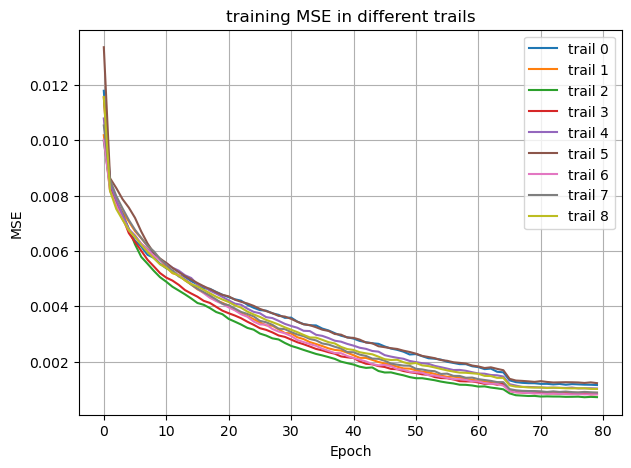

In [25]:
# training 
x = np.array(train_trails)
plt.figure(figsize=(7,5))
index = 0
for i in range(0, 9):
    t = x[index: index+80]
    index=index+80
    plt.plot(t, label=f'trail {i}')
plt.title('training MSE in different trails')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()

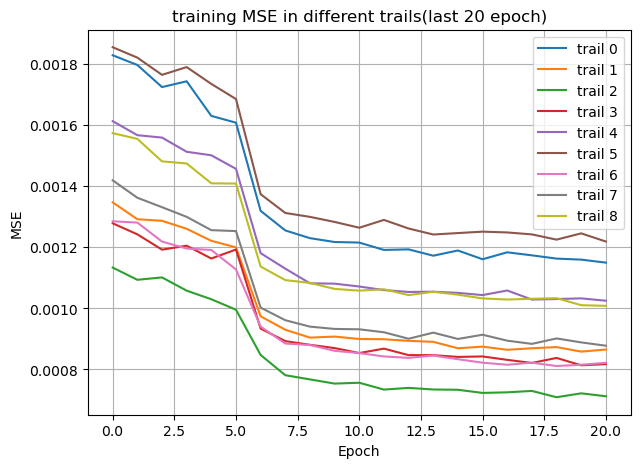

In [26]:
# training 
x = np.array(train_trails)
plott_20(x, "training")

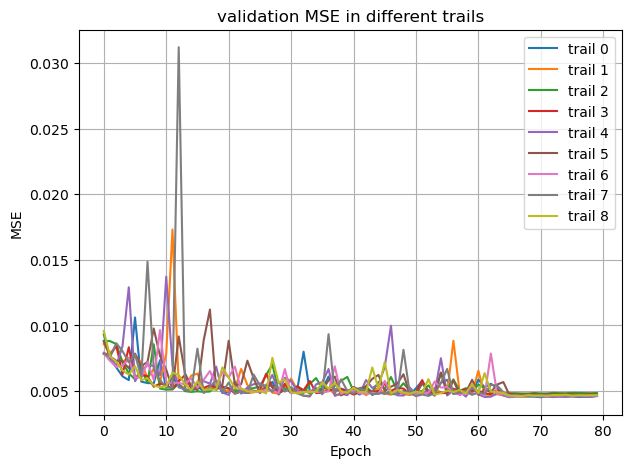

In [27]:
# validation
x = np.array(validate_trails)
plott(x, "validation")

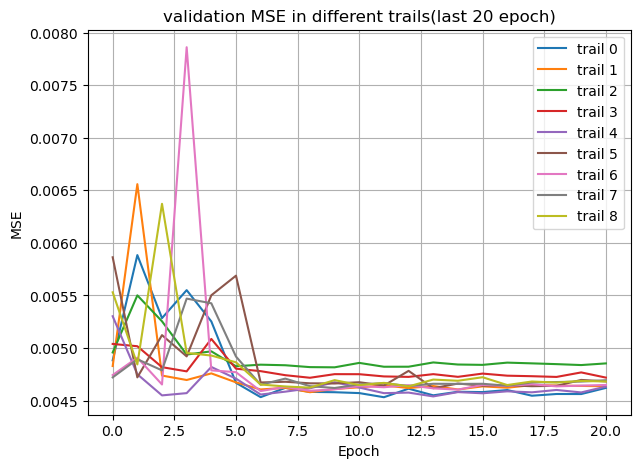

In [28]:
# validation
x = np.array(validate_trails)
plott_20(x, "validation")

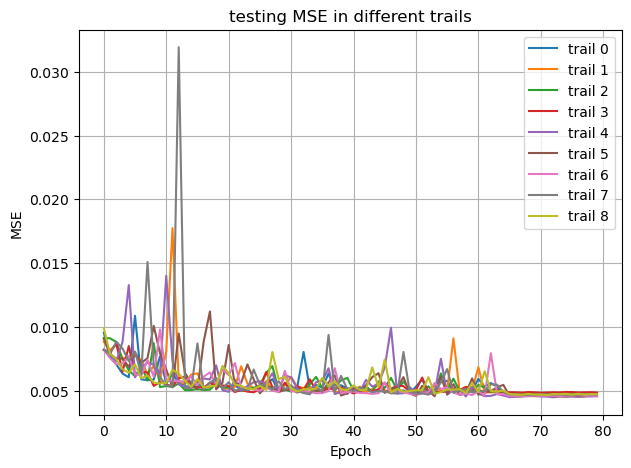

In [29]:
# testing 
x = np.array(test_trails)
plott(x, "testing")

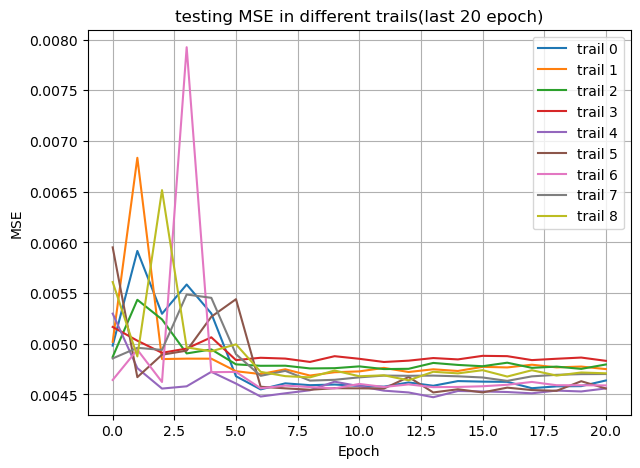

In [30]:
# testng
x =  np.array(test_trails)
plott_20(x, "testing")

## plot the best velidation MSE and testing MSE

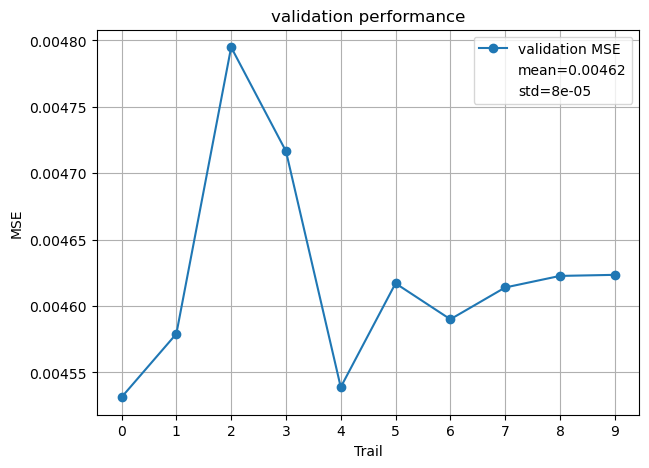

validation mean= 0.004622837082224588
validation std= 7.54324220486177e-05


In [31]:
x = vali
plt.figure(figsize=(7,5))
plt.title('validation performance')
plt.plot(x, label='validation MSE',marker='o')
plt.plot([], [], ' ', label=f"mean={round(np.mean(x),5)}")
plt.plot([], [], ' ', label=f"std={round(np.std(x),5)}")
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()
print("validation mean=",np.mean(x))
print("validation std=",np.std(x))

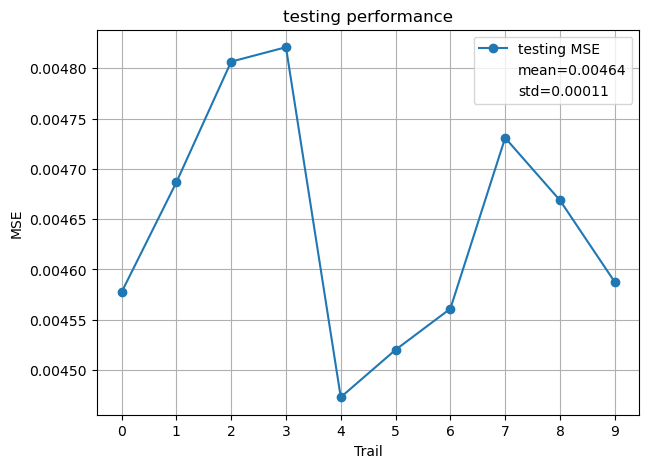

testing mean= 0.00464331838483008
testing std= 0.00011263676520538678


In [32]:
x = testing
plt.figure(figsize=(7,5))
plt.title('testing performance')
plt.plot(x, label='testing MSE',marker='o')
plt.plot([], [], ' ', label=f"mean={round(np.mean(x),5)}")
plt.plot([], [], ' ', label=f"std={round(np.std(x),5)}")
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()
print("testing mean=",np.mean(x))
print("testing std=",np.std(x))

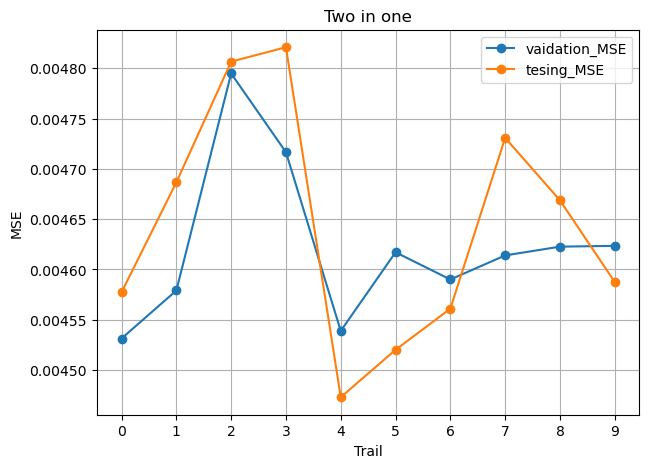

In [33]:
x1 = vali
x2 = testing
plt.figure(figsize=(7,5))
plt.title('Two in one')
plt.plot(x1, label='vaidation_MSE',marker='o')
plt.plot(x2, label='tesing_MSE',marker='o')
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()

## Save CSV

In [34]:
x1 = np.array(vali).reshape(1, -1)
x2 = np.array(testing).reshape(1, -1)
two = np.vstack((x1,x2))
df = pd.DataFrame(two).T
df.to_csv(os.path.join(os.getcwd(),"training_process") + "\\s6_learnable_add_ctp.csv")

In [35]:
# save data 
x1 = np.array(train_trails).reshape(1, -1)
x2 = np.array(validate_trails).reshape(1, -1)
x3 = np.array(test_trails).reshape(1, -1)
three = np.vstack((x1,x2,x3))
df = pd.DataFrame(three).T
df.to_csv(os.path.join(os.getcwd(),"training_process") + "\\s6_learnable_add_whole_ctp.csv")